In [173]:
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

In [174]:
gkvInputCatv02_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data
mergedStellarMass_gkvScience_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

In [175]:
FLUX_BINS = np.logspace(-5,-2,1000) # CORRECT THE VALUES

REGIONS_OF_SKY = {
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
    'G12': {'RAcen': (174.0, 186.0), 'DECcen': (-3.0, 2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0, 3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0, -30.0)},
}

GKV_MASKS = (
    (gkvInputCatv02_raw['uberclass'] == 1) &
    (gkvInputCatv02_raw['flux_rt'] > 10**-4.3) &
    (~gkvInputCatv02_raw['duplicate']) &
    (~gkvInputCatv02_raw['mask']) &
    (~gkvInputCatv02_raw['starmask'])
)

SPEC_MASKS = (
    (~mergedStellarMass_gkvScience_raw['duplicate']) &
    (~mergedStellarMass_gkvScience_raw['mask']) &
    (~mergedStellarMass_gkvScience_raw['starmask']) &
    (mergedStellarMass_gkvScience_raw['uberclass'] == 1) &
    (mergedStellarMass_gkvScience_raw['flux_rt'] > 10**-4.3)
)

In [176]:
gkvInputCatv02 = gkvInputCatv02_raw[GKV_MASKS]
mergedStellarMass_gkvScience = mergedStellarMass_gkvScience_raw[SPEC_MASKS]

In [177]:
#all the functions go here

def create_completeness_dataframe(big_survey, small_survey, flux_type, region):
    object_completeness = calculate_completeness_of_objects(big_survey=big_survey, small_survey=small_survey, flux_type=flux_type, region=region)
    completeness_df = pd.DataFrame()
    objects_in_one_region = filter_objects_by_region(small_survey, REGIONS_OF_SKY[region])
    completeness_df['uberID'] = objects_in_one_region['uberID'].byteswap().newbyteorder()
    completeness_df['completeness'] = object_completeness
    completeness_df = completeness_df.dropna(subset=['completeness'])
    return completeness_df

def calculate_completeness_of_objects(big_survey, small_survey, flux_type, region):
    cumulative_completeness = get_cumulative_completeness(
        big_survey=big_survey,
        small_survey=small_survey,
        flux_type=flux_type,
        region=region
    )
    objects_in_one_region = filter_objects_by_region(small_survey, REGIONS_OF_SKY[region])
    return np.interp(objects_in_one_region[flux_type], FLUX_BINS[:-1], cumulative_completeness)

def get_cumulative_completeness(big_survey, small_survey, flux_type, region):
    number_of_obj_big_survey, number_of_obj_small_survey = get_stat(big_survey=big_survey, small_survey=small_survey, flux_type=flux_type,region=region)
    return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)

def get_stat(big_survey, small_survey, flux_type, region):
    big_survey_region = filter_objects_by_region(big_survey, REGIONS_OF_SKY[region])
    small_survey_region = filter_objects_by_region(small_survey, REGIONS_OF_SKY[region])
    counts_of_big_survey = get_interval_counts_from_surveys(survey_name=big_survey_region , flux_type=flux_type)
    counts_of_small_survey = get_interval_counts_from_surveys(survey_name=small_survey_region , flux_type=flux_type)
    return counts_of_big_survey, counts_of_small_survey

def get_interval_counts_from_surveys(survey_name, flux_type):
    flux_list = read_flux(survey_name,flux_type)
    interval_counts = count_objects_in_flux_intervals(flux_list, FLUX_BINS)
    return interval_counts

def read_flux(survey_name, flux_type):
    return survey_name[flux_type]

def count_objects_in_flux_intervals(flux_data, intervals):
    counts = np.histogram(flux_data, bins=intervals)[0]
    return counts

def filter_objects_by_region(survey_name, region):
    RAcen_mask = (survey_name['RAcen'] >= region['RAcen'][0]) & (survey_name['RAcen'] <= region['RAcen'][1])
    DECcen_mask = (survey_name['DECcen'] >= region['DECcen'][0]) & (survey_name['DECcen'] <= region['DECcen'][1])
    return survey_name[RAcen_mask & DECcen_mask]

def calculate_ratio_between_surveys(counts_small_survey, counts_big_survey):
    ratio = (counts_small_survey / counts_big_survey) * 100
    return ratio

In [178]:
print(len(create_completeness_dataframe(gkvInputCatv02,mergedStellarMass_gkvScience,'flux_rt','G09')))

/tmp/ipykernel_38446/1479310834.py:24: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


48948


In [179]:
# Apply masks
gkvInputCatv02 = gkvInputCatv02_raw[GKV_MASKS]
mergedStellarMass_gkvScience = mergedStellarMass_gkvScience_raw[SPEC_MASKS]

/tmp/ipykernel_38446/1479310834.py:24: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


UberID: 138021052006945, Completeness: 0.9632823852564064
UberID: 131010293406270, Completeness: 0.9031443672073178
UberID: 216011091408416, Completeness: 0.9006575204954398
UberID: 136000563202354, Completeness: 0.9587312800867009
UberID: 345690124605004, Completeness: 0.9580817485438121
UberID: 341690300008314, Completeness: 0.9671585742728915
UberID: 215010867008644, Completeness: 0.8766470627162417
UberID: 130020205007803, Completeness: 0.9671863114288843
UberID: 341690300608026, Completeness: 0.8824815243046711
UberID: 219980504410116, Completeness: 0.9478537460984853
UberID: 138021052006945, Completeness: 0.9693093089103736
UberID: 131010293406270, Completeness: 0.9612899493248218
UberID: 216011091408416, Completeness: 0.9751807049333708
UberID: 136000563202354, Completeness: 0.9689843113075126
UberID: 345690124605004, Completeness: 0.9770151425199818
UberID: 341690300008314, Completeness: 0.9369635187269888
UberID: 215010867008644, Completeness: 0.972292824770483
UberID: 1300202

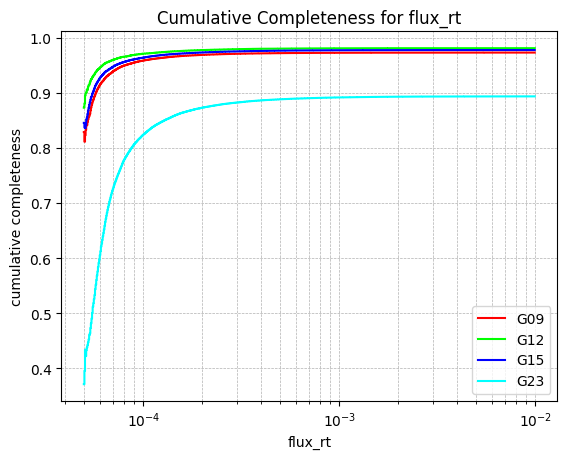

UberID: 138021052006945, Completeness: 0.9648436629126315
UberID: 131010293406270, Completeness: 0.9197233432289156
UberID: 216011091408416, Completeness: 0.9267705306831898
UberID: 136000563202354, Completeness: 0.9604964922898883
UberID: 345690124605004, Completeness: 0.9489038213634138
UberID: 341690300008314, Completeness: 0.9675006979911459
UberID: 215010867008644, Completeness: 0.9142237589469299
UberID: 130020205007803, Completeness: 0.968203803806165
UberID: 341690300608026, Completeness: 0.9519423611018704
UberID: 219980504410116, Completeness: 0.9392106236212087
UberID: 138021052006945, Completeness: 0.9681743925532276
UberID: 131010293406270, Completeness: 0.9629380866322649
UberID: 216011091408416, Completeness: 0.9744165905028689
UberID: 136000563202354, Completeness: 0.9701257775459043
UberID: 345690124605004, Completeness: 0.9773947400905323
UberID: 341690300008314, Completeness: 0.9515361670489648
UberID: 215010867008644, Completeness: 0.9738887791911615
UberID: 1300202

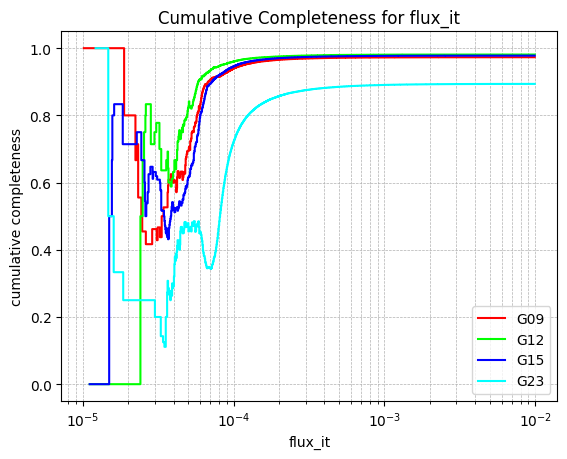

UberID: 138021052006945, Completeness: 0.963916964788638
UberID: 131010293406270, Completeness: 0.9227984141972332
UberID: 216011091408416, Completeness: 0.930788584077218
UberID: 136000563202354, Completeness: 0.961141951999925
UberID: 345690124605004, Completeness: 0.912435463470612
UberID: 341690300008314, Completeness: 0.9683459831252277
UberID: 215010867008644, Completeness: 0.9209702518820702
UberID: 130020205007803, Completeness: 0.9683709755602005
UberID: 341690300608026, Completeness: 0.9562782150650951
UberID: 219980504410116, Completeness: 0.928001141977148
UberID: 138021052006945, Completeness: 0.9631119573496347
UberID: 131010293406270, Completeness: 0.9619515006952329
UberID: 216011091408416, Completeness: 0.973445853513506
UberID: 136000563202354, Completeness: 0.9706140512455175
UberID: 345690124605004, Completeness: 0.9775975780627818
UberID: 341690300008314, Completeness: 0.9536797329736173
UberID: 215010867008644, Completeness: 0.9741976876921038
UberID: 130020205007

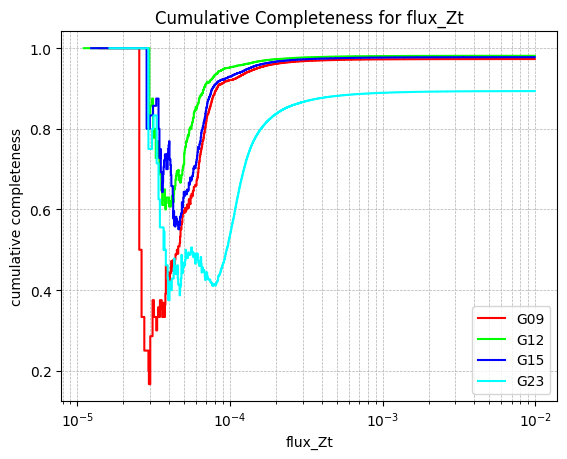

In [172]:
flux_types = ['flux_rt', 'flux_it', 'flux_Zt']
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}

for flux_type in flux_types:
    # Plot cumulative completeness for all regions
    for region in REGIONS_OF_SKY:
        object_completeness = calculate_completeness_of_objects(big_survey=gkvInputCatv02, small_survey=mergedStellarMass_gkvScience, flux_type=flux_type, region=region)

        # Display UberID and completeness for each object
        for i, (uberID, completeness) in enumerate(zip(mergedStellarMass_gkvScience['uberID'], object_completeness)):
            if i < 10:  # Display only the first 10 objects as an example
                print(f'UberID: {uberID}, Completeness: {completeness}')
            else:
                break
        cumulative_completeness = get_cumulative_completeness(big_survey=gkvInputCatv02, small_survey=mergedStellarMass_gkvScience, flux_type=flux_type, region=region)

        plt.step(FLUX_BINS[:-1], cumulative_completeness, label=region, color=region_colors[region])

    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel(f'{flux_type}')
    plt.ylabel('cumulative completeness')
    plt.legend()
    plt.title(f'Cumulative Completeness for {flux_type}')
    plt.show()


/tmp/ipykernel_38446/3093764844.py:22: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


UberID: 138021052006945, Completeness: 0.9632823852564064
UberID: 131010293406270, Completeness: 0.9031443672073178
UberID: 216011091408416, Completeness: 0.8486006054325705
UberID: 136000563202354, Completeness: 0.9006575204954398
UberID: 345690124605004, Completeness: 0.9703193260668879
UberID: 341690300008314, Completeness: 0.9710776171757395
UberID: 215010867008644, Completeness: 0.9226462611648429
UberID: 130020205007803, Completeness: 0.9587312800867009
UberID: 341690300608026, Completeness: 0.9497908086020458
UberID: 219980504410116, Completeness: 0.9625036026125562
UberID: 138021052006945, Completeness: 0.9736376458288467
UberID: 131010293406270, Completeness: 0.939586220415649
UberID: 216011091408416, Completeness: 0.9067390248752545
UberID: 136000563202354, Completeness: 0.9381469515765329
UberID: 345690124605004, Completeness: 0.9787045537245546
UberID: 341690300008314, Completeness: 0.9794294979195286
UberID: 215010867008644, Completeness: 0.9514379192405197
UberID: 1300202

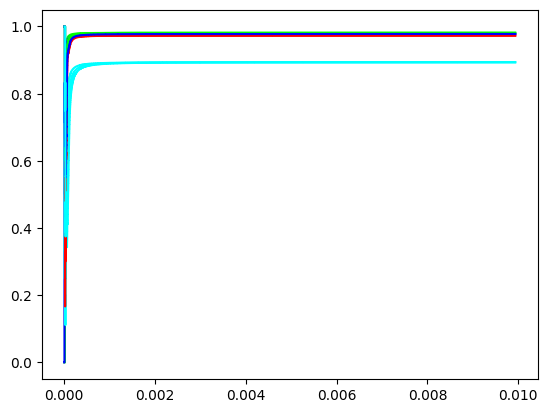

In [148]:
for flux_type in flux_types:
    # Create a dictionary to store the count of objects for each region
    object_count_by_region = {}

    # Plot cumulative completeness for all regions
    for region in REGIONS_OF_SKY:
        object_completeness = calculate_completeness_of_objects(big_survey=gkvInputCatv02, small_survey=mergedStellarMass_gkvScience, flux_type=flux_type, region=region)

        # Count the number of objects in the current region
        num_objects_in_region = len(object_completeness)
        object_count_by_region[region] = num_objects_in_region

        # Display UberID and completeness for each object
        for i, (uberID, completeness) in enumerate(zip(mergedStellarMass_gkvScience['uberID'], object_completeness)):
            if i < 10:  # Display only the first 10 objects as an example
                print(f'UberID: {uberID}, Completeness: {completeness}')
            else:
                break

        cumulative_completeness = get_cumulative_completeness(big_survey=gkvInputCatv02, small_survey=mergedStellarMass_gkvScience, flux_type=flux_type, region=region)

        plt.step(FLUX_BINS[:-1], cumulative_completeness, label=region, color=region_colors[region])

    # Print the count of objects in each region
    print(f'Number of objects in each region for {flux_type}: {object_count_by_region}')


In [180]:
print(len(create_completeness_dataframe(big_survey=gkvInputCatv02, small_survey=mergedStellarMass_gkvScience, flux_type=flux_type, region='G09')))


/tmp/ipykernel_38446/1479310834.py:24: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


48947
